In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GMM
from scipy.stats import norm
from matplotlib.patches import Ellipse
import os
import seaborn as sns
from astropy.io import fits

from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

from thesis_code.fits import load as myload

/Users/kburleigh/miniconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  7


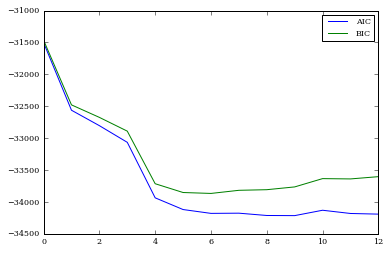

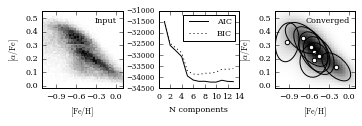

In [26]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print N[i]
        models[i] = GMM(n_components=N[i], n_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

for name,criteria in zip(['AIC','BIC'],[AIC,BIC]):
    plt.plot(range(len(criteria)),criteria,label=name)
plt.legend(loc='upper right')

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:])))).T
log_dens = gmm_best.score(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 1.66))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

# plt.show()

NameError: name 'log_dens' is not defined

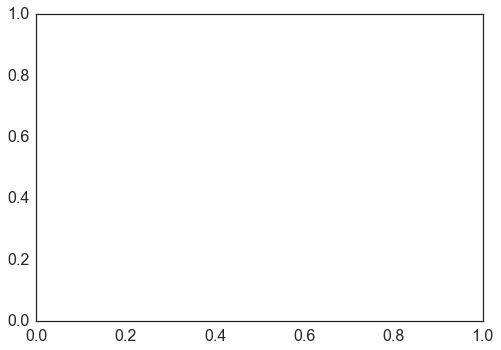

In [15]:
# plot best configurations for AIC and BIC
def add_MoG_curves(ax, means_, covars_, weights_):
    ax.scatter(means_[:, 0], means_[:, 1], c='w')
    scale=2.
    cnt=0
    for mu, C, w in zip(means_, covars_, weights_):
        print 'cnt=%d, wt=' % cnt,w
    #     draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')
        # Draw MoG outlines
        sigma_x2 = C[0, 0]
        sigma_y2 = C[1, 1]
        sigma_xy = C[0, 1]

        alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
        tmp1 = 0.5 * (sigma_x2 + sigma_y2)
        tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

        sigma1 = np.sqrt(tmp1 + tmp2)
        sigma2 = np.sqrt(tmp1 - tmp2)

        ax.text(mu[0],mu[1],str(cnt),color='blue')
        ax.add_patch(Ellipse((mu[0], mu[1]),
                     2 * scale * sigma1, 2 * scale * sigma2,
                     alpha * 180. / np.pi,\
                     fc='none', ec='k'))
        cnt+=1



fig,ax=plt.subplots()
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
# MoG components
add_MoG_curves(ax, gmm_best.means_, gmm_best.covars_, gmm_best.weights_)
# Label
ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

In [21]:
def sample(self, n_samples=1, random_state=None):
    if self.covtype != 'full':
        return NotImplementedError(
            'covariance type "{0}" not implemented yet.'.format(self.covtype))

    # Code adapted from sklearn's GMM.sample()
    if random_state is None:
        random_state = np.random.RandomState()

    weight_cdf = np.cumsum(self.weights)
    X = np.empty((n_samples, self.n_dimensions))
    rand = random_state.rand(n_samples)
    # decide which component to use for each sample
    comps = weight_cdf.searchsorted(rand)
    # for each component, generate all needed samples
    for comp in range(self.n_components):
        # occurrences of current component in X
        comp_in_X = (comp == comps)
        # number of those occurrences
        num_comp_in_X = comp_in_X.sum()
        if num_comp_in_X > 0:
            X[comp_in_X] = random_state.multivariate_normal(
                self.means[comp], self.covars[comp], num_comp_in_X)
    return X

In [33]:
weight_cdf= np.cumsum(gmm_best.weights_)
randsd=np.random.RandomState()
rand = randsd.rand(10)
# decide which component to use for each sample
result= weight_cdf.searchsorted(rand)
print weight_cdf
print rand
print result

[ 0.09940217  0.16816626  0.33967488  0.56168694  0.69226384  0.89347038
  1.        ]
[ 0.33716436  0.88063326  0.99200097  0.04095968  0.90151202  0.5606042
  0.49451773  0.38379037  0.76564743  0.34569735]
[2 5 6 0 6 3 3 3 5 3]


# Improved MOG sampling

In [8]:
# Class to read, write, and sample from a mixture model.
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covars_, name='covars'))
        hdus.writeto(filename, clobber=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X
    


cnt=0, wt= 0.142785544521
cnt=1, wt= 0.24574593774
cnt=2, wt= 0.105611043984
cnt=3, wt= 0.126550474507
cnt=4, wt= 0.368482063936
cnt=5, wt= 0.010824935312


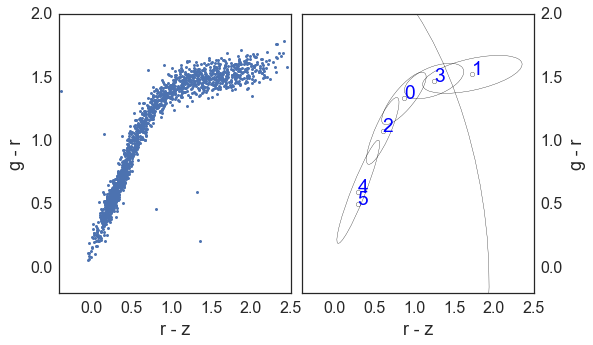

In [123]:
mog = GaussianMixtureModel.load('star_colors_mog.fits')
samp = mog.sample(1500)
# Build a color-color plot.  Show the data on the left-hand panel and random draws from 
# the MoGs on the right-hand panel.
sns.set(style='white', font_scale=1.6, palette='deep')
col = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 5), sharey=True)
grrange = (-0.2, 2.0)
rzrange = (-0.4, 2.5)

ax1.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[0], markersize=3)
ax1.set_xlim(rzrange)
ax1.set_ylim(grrange)
ax1.set_xlabel('r - z')
ax1.set_ylabel('g - r')
#ax1.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

add_MoG_curves(ax2, mog.means, mog.covars, mog.weights)
ax2.set_xlim(rzrange)
ax2.set_ylim(grrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('r - z')
ax2.set_ylabel('g - r')
# ax2.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# plt.show()
plt.savefig('stars.png')

In [28]:
mog.weights

array([ 0.14278554,  0.24574594,  0.10561104,  0.12655047,  0.36848206,
        0.01082494])

In [36]:
a=np.arange(10)
b=np.arange(10)
# c=np.concatenate
# np.concatenate((a,b),axis=0).shape
c=np.array([a,b]).T
np.sum(c,axis=1).shape

(10,)

In [42]:
np.sum(np.zeros((10,10,2)),axis=2).shape

(10, 10)

In [133]:
from scipy.stats import multivariate_normal
def get_mv(means_,covars_):
    mv=[]
    for mu, C in zip(means_, covars_):
        mv+= [ multivariate_normal(mean=mu, cov=C) ]
    return mv
        
def prob_map(means_,covars_,weights_,\
             xrng=(0.,1.),yrng=(0.,1.),npts=2**10):
    '''returns 
    -pmap: 2d probability map, with requirement that integral(pdf d2x) within 1% of 1
    -xvec,yvec: vectors where x[ix] and y[ix] data points have probability pmap[ix,iy]'''
    assert(xrng[1] > xrng[0] and yrng[1] > yrng[0])
    xstep= (xrng[1]-xrng[0])/float(npts-1)
    ystep= (yrng[1]-yrng[0])/float(npts-1)
    x,y  = np.mgrid[xrng[0]:xrng[1]+xstep:xstep, yrng[0]:yrng[1]+ystep:ystep]
    pos = np.empty(x.shape + (2,)) #npts x npts x 2
    pos[:, :, 0] = x; pos[:, :, 1] = y
    maps= np.zeros(x.shape+ (len(weights_),)) # x n_components
    # Multi-Variate function
    mv= get_mv(means_,covars_)
    # probability map for each component
    for dist,W,cnt in zip(mv,weights_, range(len(weights_))):
        maps[:,:,cnt]= dist.pdf(pos) * W
        print "map %d, dist.pdf max=%.2f, wt=%.3f" % (cnt,dist.pdf(pos).max(),W)
    # summed prob map
    pmap= np.sum(maps, axis=2) #some over components*weights
    xvec= x[:,0]
    yvec= y[0,:]
    # intregal of pdf over 2d map = 1
#     assert( abs(1.- pmap.sum()*xstep*ystep) <= 0.01 )
    assert( np.diff(xvec).min() > 0. and np.diff(yvec).min() > 0.)
    return pmap, xvec,yvec
    

# pmap,xvec,yvec= prob_map(mog.means,mog.covars,mog.weights,\
#                          xrng=rzrange,yrng=grrange)
pmap,xvec,yvec= prob_map(mog.means[:-1,...],mog.covars[:-1,...],mog.weights[:-1],\
                         xrng=rzrange,yrng=grrange)



map 0, dist.pdf max=19.09, wt=0.143
map 1, dist.pdf max=8.06, wt=0.246
map 2, dist.pdf max=22.52, wt=0.106
map 3, dist.pdf max=14.44, wt=0.127
map 4, dist.pdf max=16.28, wt=0.368


In [130]:
mog.covars.shape

(6, 2, 2)

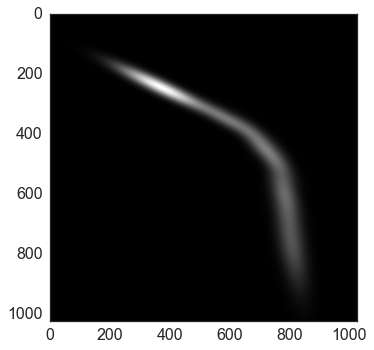

In [134]:
plt.imshow(pmap/pmap.max(),cmap='gray')

In [119]:
def improved_sample(pmap,xvec,yvec, nsamples=1500):
    # Make max pdf = 1 so always pick that cell
    pmap/= pmap.max()
    # Store x,y values to use
    store_xy= np.zeros((nsamples,2))+np.nan
    # Get samples
    r=np.random.RandomState()
    cnt=0
    # pick a random cell
    ix,iy=(r.rand(2)*len(xvec)).astype(int)
    # Random [0,1)
    likely= r.rand(1)
    while cnt < nsamples:
        if likely <= pmap[ix,iy]: # Sample it!
            store_xy[cnt,:]= xvec[ix],yvec[iy]
            cnt+=1
        # Pick new cell in either case
        ix,iy=(r.rand(2)*len(xvec)).astype(int) 
        likely= r.rand(1)
#     assert( np.where(not np.isfinite(store_xy))[0].size == 0)
    assert( np.where(~np.isfinite(store_xy))[0].size == 0)
    return store_xy[:,0],store_xy[:,1]
            



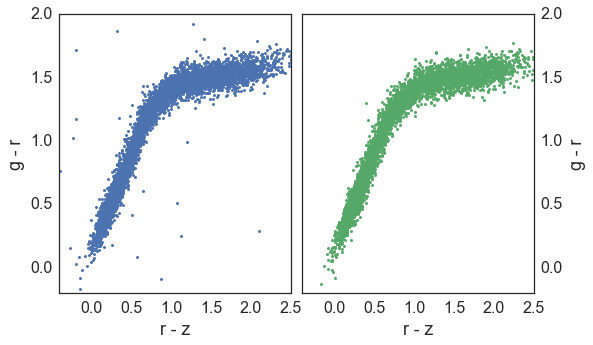

In [135]:
nsamp=5000
rz,gr= improved_sample(pmap,xvec,yvec, nsamples=nsamp)

mog = GaussianMixtureModel.load('star_colors_mog.fits')
samp = mog.sample(nsamp)
# Build a color-color plot.  Show the data on the left-hand panel and random draws from 
# the MoGs on the right-hand panel.
sns.set(style='white', font_scale=1.6, palette='deep')
col = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 5), sharey=True)
grrange = (-0.2, 2.0)
rzrange = (-0.4, 2.5)

ax1.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[0], markersize=3)
ax1.set_xlim(rzrange)
ax1.set_ylim(grrange)
ax1.set_xlabel('r - z')
ax1.set_ylabel('g - r')
#ax1.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

# add_MoG_curves(ax2, mog.means, mog.covars, mog.weights)
ax2.plot(rz, gr, 'o', label='Random Draws', c=col[1], markersize=3)
ax2.set_xlim(rzrange)
ax2.set_ylim(grrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('r - z')
ax2.set_ylabel('g - r')
# ax2.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# plt.show()
plt.savefig('stars.png')

(0.0, 9.0)

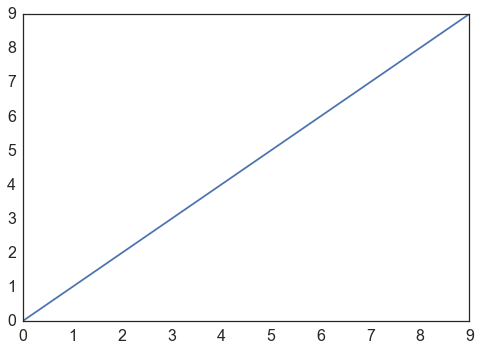

In [142]:
plt.plot(range(10))
plt.ylim(None)

# VIPERS following David's idl script

In [64]:
# dr2=fits.load('/Users/kburleigh/VIPERS/tractor-dr2-VIPERS-W4.fits.gz')
# pcat= fits.load('/Users/kburleigh/VIPERS/VIPERS_W4_PHOT_PDR1.fits')
# dr2=dr2[:10000]
# pcat=pcat[:10000]
# dr2.write('tractor-dr2-VIPERS-W4_10Krows.fits')
# pcat.write('VIPERS_W4_PHOT_PDR1_10Krows.fits')
# Read in shortened tables (first 10k rows)
dr2= fits.load('tractor-dr2-VIPERS-W4_10Krows.fits')
pcat=fits.load('VIPERS_W4_PHOT_PDR1_10Krows.fits')
zcat = fits.load('/Users/kburleigh/VIPERS/VIPERS_W4_SPECTRO_PDR1.fits')

In [75]:
# for key in ['POINTING','QUADRANT','ZFLG','ZSPEC','EPOCH','TSR','SSR']: print key.lower(),key.lower() in zcat.colnames,key.lower() in pcat.colnames
# zcat.colnames, pcat.colnames

In [76]:
from astropy.table import join
# Inner join gives item if in both tables
both = join(zcat, pcat, keys=['id_IAU'], join_type='inner')

In [85]:
# Keep if within 20 arcsec of some DECam source
from thesis_code.matching import johan_tree
i1,i2,dist= johan_tree(dr2['RA'],dr2['DEC'], both['alpha_1'],both['delta_1'], k=1, dsmax=20./3600)
dr2=dr2[i1]
both=both[i2]

38/10000 Refs matched, 9962/10000 Refs unmatched


In [2]:
# David: why dr2['shapedev_r'.upper()] > dr2['shapeexp_r'.upper()] ? 
# David: why rmag < 23?
# i'm ignoring these b/c zflux limited
flux={}
for band,iband in zip(['g','r','z'],[1,2,4]):
    flux[band]= dr2['DECAM_FLUX'][:,iband] / dr2['DECAM_MW_TRANSMISSION'][:,iband]
for band,iband in zip(['w1','w2'],[0,1]):
    flux[band]= dr2['WISE_FLUX'][:,iband] / dr2['WISE_MW_TRANSMISSION'][:,iband]

NameError: name 'dr2' is not defined

In [120]:
mag={}
for band in ['g','r','z','w1','w2']:
    mag[band]= 22.5-2.5*np.log10(flux[band])

def clean_cut(dr2):
    return np.all((dr2['DECAM_FLUX'].data[:,1] > 0,\
                   dr2['DECAM_FLUX'].data[:,2] > 0,\
                   dr2['DECAM_FLUX'].data[:,4] > 0, \
                   dr2['DECAM_ANYMASK'].data[:,1] == 0,\
                   dr2['DECAM_ANYMASK'].data[:,2] == 0,\
                   dr2['DECAM_ANYMASK'].data[:,4] == 0,\
                   dr2['DECAM_FRACFLUX'].data[:,1] <= 0.05,\
                   dr2['DECAM_FRACFLUX'].data[:,2] <= 0.05,\
                   dr2['DECAM_FRACFLUX'].data[:,4] <= 0.05,\
                   dr2['BRICK_PRIMARY'].data == 'T'),axis=0)
keep= clean_cut(dr2)

/Users/kburleigh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/kburleigh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [118]:
def lrg_cut(flux):
    return np.all((flux['z'] > 10**((22.5-20.46)/2.5),\
                   flux['z'] > flux['r']*10**(1.5/2.5),\
                   flux['w1']*np.power(flux['r'],1.8-1) > np.power(flux['z'],1.8)*10**(-1.0/2.5),\
                   flux['w1'] > 0),axis=0)

def extra_cut(dr2):
    return np.all((dr2['DECAM_ANYMASK'].data[:,1] == 0,\
                   dr2['DECAM_ANYMASK'].data[:,2] == 0,\
                   dr2['DECAM_ANYMASK'].data[:,4] == 0,\
                   dr2['DECAM_FRACFLUX'].data[:,1] <= 0.05,\
                   dr2['DECAM_FRACFLUX'].data[:,2] <= 0.05,\
                   dr2['DECAM_FRACFLUX'].data[:,4] <= 0.05,\
                   dr2['BRICK_PRIMARY'].data == 'T'),axis=0)
    
i_lrg= lrg_cut(flux)*extra_cut(dr2)

/Users/kburleigh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/Users/kburleigh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [117]:
def good_z(both):
    flag= both['zflg'].data.astype(int)
    return np.all((flag >= 2, flag <=9),axis=0)

keep_z= good_z(both)

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 29, 30, 31, 32, 33, 34, 35, 36, 37])

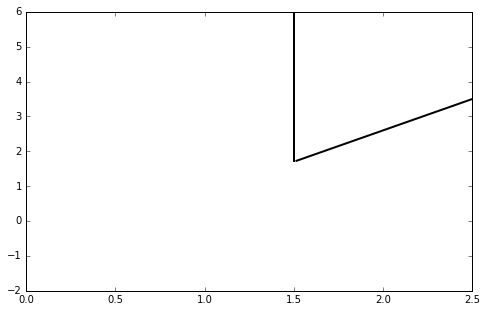

In [125]:
i_final= i_lrg*keep_z
fig, ax = plt.subplots(1, 1, figsize=(8,5))
rw1= (-2.,6.)
rz = (0.,2.5)
def get_color(mag, index,inbox=False):
    rw1= mag['r'][index] - mag['w1'][index]
    rz= mag['r'][index]- mag['z'][index]
    return rw1, rz
x,y= get_color(mag, keep_z)
ax.scatter(x, y, marker='^', color='b', label='all z')
ax.set_xlim(rz)
ax.set_ylim(rw1)

# Target Selection box
def fx(x,name):
    if name == 'y1': return 1.8*x-1.
    else: raise ValueError

x=np.linspace(rz[0],rz[1],num=100)
y=np.linspace(rw1[0],rw1[1],num=100)
x1,y1= x,fx(x,'y1')
x2,y2= np.array([1.5]*len(x)),y
b= x >= 1.5
x1,y1= x1[b],y1[b]
b= y2 >= fx(1.5,'y1')
x2,y2= x2[b],y2[b]
ax.plot(x1,y1,'k-',lw=2)
ax.plot(x2,y2,'k-',lw=2)


In [57]:
def fx(x,name,bnds):
    if name == 'y1': return 1.15*x-0.15
    elif name == 'y2': return -1.2*x+1.6
    else: raise ValueError
    
def fx_diff(x,name,bnds):
    if name == 'y1-y2': return fx(x,'y1',bnds)-fx(x,'y2',bnds)
    else: raise ValueError
    
#     if name == 'y2-y1':
#         return -1+2.*x
#     else: raise ValueError
#     grrange = (-0.3,2.0)
#     rzrange = (-0.5,2.1)
# #     x=np.linspace(rzrange[0],rzrange[1],num=100)
#     y=np.linspace(grrange[0],grrange[1],num=len(x))
#     x1,y1= x,1.15*x-0.15
#     x2,y2= [0.3]*len(x),y
#     return y2-y1
from scipy.optimize import brentq, newton
from scipy.optimize import minimize, rosen, rosen_der
# x0 = [0]
# res = minimize(fx, x0, method='Nelder-Mead',bounds=tuple((-1,2))) #, tol=1e-6)
# if not res.success: print "minimization failed: %s" % res.message
# print newton(fx,-1,args=('y2-y1',))

In [58]:
print newton(fx_diff,np.array([1.]),args=('y1-y2',[-0.3,2.0]))

[ 0.74468085]


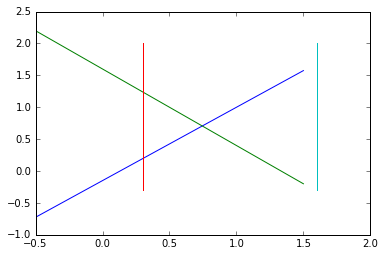

In [49]:
x=np.arange(-0.5,2.1)
plt.plot(x,fx(x,'y1',[-0.3,2.0]))
plt.plot(x,fx(x,'y3',[-0.3,2.0]))
x=[0.3]*2
plt.plot(x,fx(x,'y2',[-0.3,2.0]))
x=[01.6]*2
plt.plot(x,fx(x,'y4',[-0.3,2.0]))
    

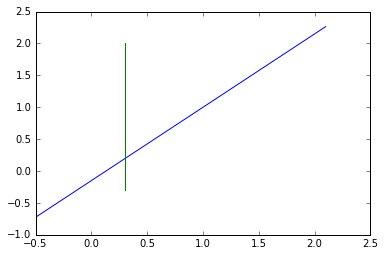

In [19]:
grrange = (-0.3,2.0)
rzrange = (-0.5,2.1)
x=np.linspace(rzrange[0],rzrange[1],num=100)
y=np.linspace(grrange[0],grrange[1],num=100)
x1,y1= x,1.15*x-0.15
x2,y2= [0.3]*len(x),y
plt.plot(x1,y1)
plt.plot(x2,y2)